In [2]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/bm/readme/examples/tutorials/tracking_particle_using_pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# DeepTrack 2.0 - Tracking particle using PyTorch

This tutorial demonstrates how to track a point particle with a convolutional neural network defined using pytorch.

Specifically, this tutotial explains how to: 
* Define the procedure to generate training images
* Extract information from these images to use as labels for the training
* Define and train a neural network model defined using pytorch
* Visually evaluate the quality of the neural network output

The notebook follows the example of [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [3]:
import deeptrack as dt

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

# Grabs the device to use for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"PyTorch will use {device} for training.")

PyTorch will use cpu for training.


## 2. Define the particle

For this example, we consider a spherical particle. Specifically, scattering of a spherical particle as determined by mie thery. For this, we use `MieSphere` (see also [scatterers_example](../examples/scatterers_example.ipynb)), whose properties are controlled by the following parameters:

* `refractive_index`: The refractive index of the particle

* `radius`: The radius of the marticle

* `position`: The position of the point particle

* `position_unit`: "pixel" or "meter"

In [4]:
mie_particle = dt.MieSphere(                                         
    refractive_index=1.58,
    radius=0.5e-6,
    position=(32, 32),
    position_unit="pixel",
)

## 3. Define the optical system 

Next, we need to define the properties of the optical system. This is done using an instance of the class `Optics` (see also [optics_example](../examples/optics_example.ipynb)), which takes a set of particles (light scatterers) and convolves them with the pupil function (point spread function) of the optical system. In this tutorial, there is only one light scatterer (here, `mie_particle`).

The optics is controlled by the following parameters:

* `NA`: The numerical aperature

* `resolution`: The effective camera pixel size (m)

* `magnification`: The magnification of the optical device

* `wavelength`: The wavelength of the lightsource (m)

* `output_region`: The position of the camera and the number of pixels (x, y, width_x, width_y)

* `upscale`: upscales all calculations. Increases accuracy at the cost of speed.

In [5]:
IMAGE_SIZE = 64

brightfield_microscope = dt.Brightfield(
    NA=0.9,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(32, 32, 32, 32),
    upscale=2
)

## 4. Create and plot the image

To view some object through an optical device, we call the optical device (here, `brightfield_microscope`) with the object we want to image (here, `point_particle`). This creates a new object (here, `imaged_particle`) that can be used to generate the desired image.

The image is finally generated by calling `imaged_particle.resolve()`.

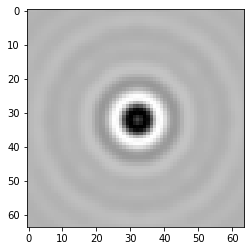

In [6]:
imaged_particle = brightfield_microscope(mie_particle)

output_image = imaged_particle.update().resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.show()

## 5. Randomize the particle position

We can generate particles with random positions by passing to the keyword argument `position` a lambda function that returns a pair of random numbers representing the particle position. We limit the scope, by asserting that the particle is at least 10 pixels from the edge of the image.

We additionally normalize the image to be between 0 and 1. It is very common that normalizing the neural network input improves the results substantially.

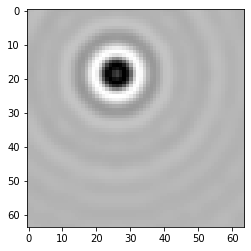

In [7]:
# Generate particle with random position

particle_with_random_position = dt.MieSphere(                                         
    refractive_index=1.58,
    radius=0.5e-6,
    position=lambda: 10 + np.random.rand(2) * (IMAGE_SIZE - 20),
    position_unit="pixel"
)

imaged_particle_with_random_position = brightfield_microscope(particle_with_random_position)

# Normalize each image between 0 and 1.
normalized_image_of_particle = imaged_particle_with_random_position + dt.NormalizeMinMax(0, 1) 

output_image = imaged_particle_with_random_position.update().resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')

The position can then be retrieved from the attribute `.position` of the generated image. `.properties` contains a list of all properties used to create the image.

Note that to simulate a particle at a new position, we need to call `.update()`

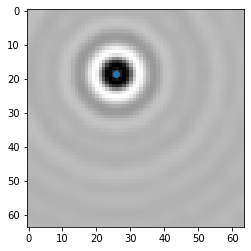

In [8]:
# Retrieve particle position

def get_position_of_particle(image):
    return image.get_property("position")

position_of_particle = get_position_of_particle(output_image)

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(position_of_particle[1], position_of_particle[0])
plt.show()

We can define a single pipeline to create both the data and the label. First we define a function `get_scaled_position_of_particle` that retrieves the position of the particle scaled between 0 and 1.
Using `>>`, we create a feature `training_labels` that evaluates this value. Finally, we use `&` to define a dataset pipeline that resolves both the image and the label.

In [9]:
# Function that retireves the position of a particle 
# and divides it by 64 to get values between 0 and 1
def get_scaled_position_of_particle(image):
    return image.get_property("position") / IMAGE_SIZE

training_labels = imaged_particle_with_random_position >> get_scaled_position_of_particle
dataset = imaged_particle_with_random_position & training_labels

We evaluate a sample from the dataset

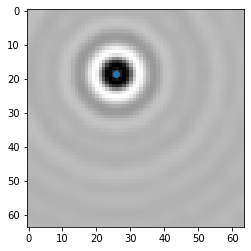

In [10]:
image_of_particle, (y, x) = dataset()
plt.imshow(np.squeeze(image_of_particle), cmap='gray')
plt.gca().scatter(x * IMAGE_SIZE, y * IMAGE_SIZE)
plt.show()

## 6. Define the neural network model

For this example, we will define the neural network using PyTorch. The network used is consists of a small convolutional netowrk, followed by a dense top. Please refer to the PyTorch documentation for more information about how to define models in PyTorch.

In [11]:
class ConvolutionalNN(nn.Module):
    def __init__(self):
        super(ConvolutionalNN, self).__init__()
        
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()

        self.dense_top = nn.Sequential(
            nn.Linear(9216, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.dense_top(x)
        return x

model = ConvolutionalNN().to(device)

print(model)

ConvolutionalNN(
  (conv_stack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_top): Sequential(
    (0): Linear(in_features=9216, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


## 7. Define image generator

Generators are objects that feed create data during training. We will be using the `PyTorchContinuousGenerator` in this tutorial. This is a convenience wrapper around `ContinuousGenerator` that prepares the data as PyTorch tensors.

In [16]:
generator = dt.generators.PyTorchContinuousGenerator(
    dataset,
    batch_function=lambda data: np.moveaxis(data[0], -1, 0),
    batch_size=16,
    min_data_size=1024,
    max_data_size=2048
)

## 8. Train the model

The model is trained by calling the method `.fit()` with the generator we defined in the previous step. Be patient, this might take some time (a few minutes).

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

with generator:
    loss_fn = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(20):
        print(f"  Epoch {epoch} ======================")
        train_loop(generator, model, loss_fn, optimizer)


Generating 1047 / 1024 samples before starting training
  Epoch 0 ======================
loss: 0.018558  [    0/   65]
  Epoch 1 ======================
loss: 0.012010  [    0/   65]
  Epoch 2 ======================
loss: 0.008640  [    0/   65]
  Epoch 3 ======================
loss: 0.009730  [    0/   65]
  Epoch 4 ======================
loss: 0.007490  [    0/   65]
  Epoch 5 ======================
loss: 0.004110  [    0/   65]
  Epoch 6 ======================
loss: 0.013760  [    0/   65]
  Epoch 7 ======================
loss: 0.004166  [    0/   65]
  Epoch 8 ======================
loss: 0.005281  [    0/   65]
  Epoch 9 ======================
loss: 0.004238  [    0/   65]


## 9. Visualize the model performance

We can now use the trained model to measure the particle position in images previously unseen by the model.

For real applications, it should be noted that the performance can be improved significantly by constraining the particle to be close to the center.

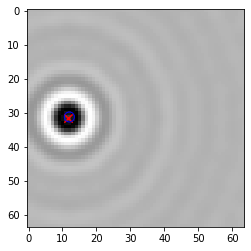

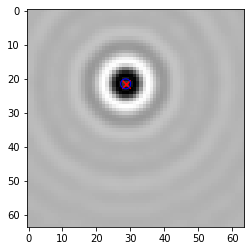

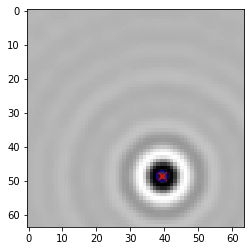

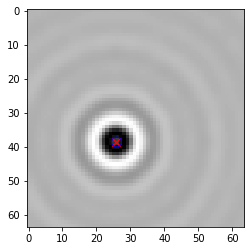

In [19]:
# generator[0] extracts one batch of images from the generator
images, real_positions = generator[0]
measured_positions = model(images).detach().numpy()

for i in range(4):
    
    image = np.squeeze(images[i])
    
    measured_position_x = measured_positions[i, 1] * IMAGE_SIZE
    measured_position_y = measured_positions[i, 0] * IMAGE_SIZE

    real_position_x = real_positions[i, 1] * IMAGE_SIZE
    real_position_y = real_positions[i, 0] * IMAGE_SIZE

    plt.imshow(image, cmap='gray')
    plt.scatter(real_position_x, real_position_y, s=70, c='r', marker='x')
    plt.scatter(measured_position_x, measured_position_y, s=100, marker='o', facecolor='none', edgecolors='b')
    plt.show()